<a href="https://colab.research.google.com/github/Violin88-tech/artificial/blob/master/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%8D%D0%BB%D0%B5%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2_%D0%BE%D0%B4%D0%B5%D0%B6%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация изображений элементов одежды

В этой части урока мы построим и обучим нейронную сеть классифицировать изображения элементов одежды, такие как платья, кроссовки, рубашки, футболки и т.п.

Всё впорядке, если какие-то моменты будут непонятны. Цель этого курса познакомить вас с TensorFlow и параллельно пояснить алгоритмы его работы и выработать общее понимание проектов использующих TensorFlow, а не углубляться в детали реализции.

В этой части мы используем `tf.keras` - высокоуровневый API для построения и тренировки моделей в TensorFlow.

## Установка и импорт зависимостей

Нам понадобится [набор данных TensorFlow](https://www.tensorflow.org/datasets/), API который упрощает загрузку и доступ к наборам данных предоставленных несколькими сервисами. Так же нам понадобится несколько вспомогательных библиотек.

In [0]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 686kB 6.5MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# импортируем TensorFlow и набор данных TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# вспомогательные библиотеки
import math
import numpy as np
import matplotlib.pyplot as plt

# Улучшим отображение прогрессбара
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

tf.enable_eager_execution()

1.14.0


##Импортируем набор данных Fashion MNIST

В этом примере используется набор данных Fashion MNIST, который содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого. Изображения содержат элементы одежды в низком разрешении (28х28 пикселей), как показано ниже:

![alt text](https://tensorflow.org/images/fashion-mnist-sprite.png)

Fashion MNIST используется как замена классическому набору данных MNIST - чаще всего используется как "Hello, World!" в машинном обучении и компьютерном зрении. Набор данных MNIST содержит изображения цифр написанных от руки (0, 1, 2 и тд) в таком же формате, каком представлены элементы одежды в нашем примере.

В нашем примере мы используем Fashion MNIST из-за разнообразия и потому, что эта задача более интересна с точки зрения реализации, чем решение типичной задачи на наборе данных MNIST. Оба наборы данных достаточно малы, поэтому используются для проверки корректной работоспособности алгоритма. Отличные наборы данных для старта изучения машинного обучения, тестирования и отладки кода.

Мы воспользуемся 60 000 изображениями для тренировки сети и 10 000 изображениями для проверки точности обучения и классификации изображений. Вы можете напрямую обращаться к набору данных Fashion MNIST через TensorFlow используя API:

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


Загружая набор данных мы получаем метаданные, обучающий набор данных и тестовый набор данных.



*   Модель обучается на наборе данных из `train_dataset`
*   Модель тестируется на наборе данных из `test_dataset`

Изображения представляют собой двумерные массивы 28х28, где значения в каждой ячейке могут быть в интервале `[0, 255]`. Метки - массив целых чисел, где каждое значение в интервале `[0, 9]`. Эти метки соответствуют выходному классу изображения следующим образом:

<table>
  <tr>
    <th>Метка</th>
    <th>Класс</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>Футболка / топ</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Шорты</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Свитер</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Платье</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Плащ</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Сандали</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Рубашка</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Кроссовок</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Сумка</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ботинок</td> 
  </tr>
</table>

Каждое изображение относится к одной метке. Так как наименования классов не содержатся в исходном наборе данных, давайте сохраним их для дальнейшего использования, когда будем отрисовывать изображения:



In [0]:
class_names = ['Футболка / топ', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

### Исследуем данные

Давайте изучим формат и структуру данных представленных в обучающем наборе перед тренировкой модели. Следующий код покажет, что 60 000 изображений находятся в обучающем наборе данных, а 10 000 изображений в тестовом наборе:

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Количество тренировочных экземпляров: {}'.format(num_train_examples))
print('Количество тестовых экземпляров: {}'.format(num_test_examples))

Количество тренировочных экземпляров: 60000
Количество тестовых экземпляров: 10000


## Предобработка данных

Значение каждого пикселя в изображении находится в интервале `[0,255]`. Для того, чтобы модель работала корректно эти значения необходимо нормализовать - привести к значениям в интервале `[0,1]`. Поэтому чуть ниже мы объявляем и реализуем функцию нормализации, а затем применяем её к каждому изображению в тренировочных и тестовых наборах данных.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

def mirror(images, labels):
  return tf.image.flip_up_down(images), labels

# метод map применяет функцию нормализации к каждому элементу в массиве
# тестовых и тренировочных наборах данных
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize).map(mirror)

### Изучаем обработанные данные

Давайте отрисуем изображение, чтобы взглянуть на него:

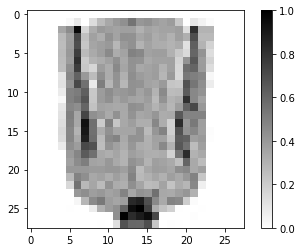

In [0]:
# Берём единственное изображение и удаляем из него цветовую составляющую
# посредством метода reshape()
for image, label in test_dataset.take(1):
  break;
image = image.numpy().reshape((28, 28))

# отрисовываем изображение
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Отобразим первые 25 изображений из тренировочного набора данных и под каждым изображением укажем к какому классу оно относится.

Убедитесь, что данные в корректном формате и мы готовы приступить к созданию и тренировки сети.

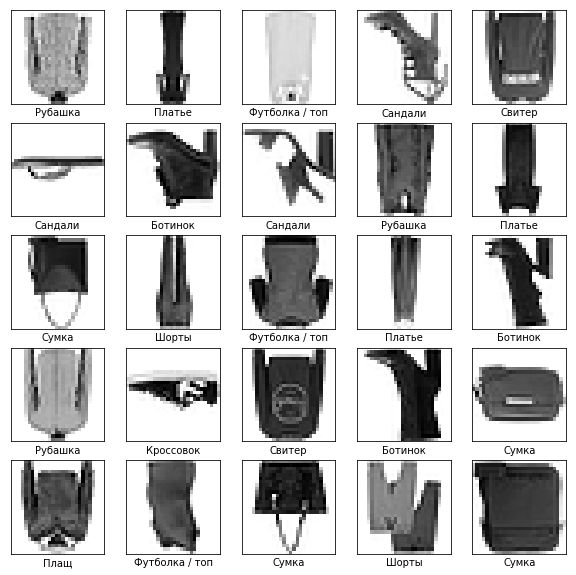

In [0]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

### Строим модель

Построение нейронной сети требует настройки слоёв, а затем сборки модели с функциями оптимизации и потерь.

###Настраиваем слои

Базовым элементом при построении нейронной сети является *слой*. Слой извлекает представление из данных, которые поступили ему на вход. Результатом работы связанных нескольких слоёв мы получаем представление, которое имеет смысл для решения поставленной задачи.

Большую часть времени занимаясь глубоким обучением вы будете заниматься созданием связей между простыми слоями. Большинство слоёв, например, такие как `tf.keras.layers.Dense` имеют набор параметров, которые могут быть "подогнаны" во время процесса обучения.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Сеть состоит из трёх слоёв:

* **входного** `tf.keras.layers.Flatten` - этот слой преобразует изображения размером 28х28 пикселей в 1D-массив размером 784 (28 * 28). На этом слое у нас нет никаких параметров для обучения, так как этот слой занимается только преобразованием входных данных.

* **скрытый слой** `tf.keras.layers.Dense` - плотносвязный слой из 128 нейронов. Каждый нейрон (узел) принимает на вход все 784 значения с предыдущего слоя, изменяет входные значения согласно внутренним весам и смещениям во время тренировки и возвращает единственное значение на следующий слой.

* **выходной слой** `ts.keras.layers.Dense` - `softmax`-слой состоит из 10 нейронов, каждый из которых представляет определённый класс элемента одежды. Как и в предыдущем слое, каждый нейрон принимает на вход значения всех 128 нейронов предыдущего слоя. Веса и смещения каждого нейрона на этом слое изменяются при обучении таким образом, чтобы результатирующее значение было в интервале `[0,1]` и представляло собой вероятность того, что изображение относится  к этому классу. Сумма всех выходных значений 10 нейронов равна 1.

###Компилируем модель

Перед тем как мы приступим к тренировке модели стоит ещё выполнить несколько настроек. Эти настройки производятся во время сборки модели при вызове метода `compile`:

* *функция потерь* - алгоритм измерения того, насколько далеко находится желаемое значение от спрогнозированного. 
* *функция оптимизации* - агоритм "подгонки" внутренних параметров (весов и смещений) модели для минимизации функции потерь;
* *метрики* - используются для мониторинга процесса тренировки и тестирования. Пример ниже использует такую метрику как `точность`, процент изображений, которые были корректно классифицированы.

In [0]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

## Тренируем модель

Во-первых, определяем последовательность действий при обучении на тренировочном наборе данных:

1. Повторяем бесконечное количество раз набор входных данных используя метод `dataset.repeat()` (параметр `epochs`, который описан ниже, определяет количество всех обучающих итераций для выполнения)
2. Метод `dataset.shuffle(60000)` перемешивает все изображения для того, чтобы на обучение нашей модели не влиял порядок подачи входных данных.
3. Метод `dataset.batch(32)` сообщает методу тренировки `model.fit` использовать блоки по 32 изображения и метки при обновлении внутренних переменных модели.

Тренировка происходит посредством вызова метода `model.fit`:
1. Отправляет `train_dataset` на вход модели.
2. Модель учится сопоставлять входное изображение с меткой.
3. Параметр `epochs=5` ограничивает количество тренировок до 5 полных обучающих итераций по набору данных, что в итоге даёт нам тренировку на 5 * 60000 = 300 000 примерах.

(на параметр `steps_per_epoch` можно не обращать внимания, скоро этот параметр будет исключён из метода)



In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

train_dataset.print(true)

AttributeError: ignored

In [0]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

В процессе тренировки модели значение функции потерь и метрика точности отображаются для каждой обучающей итерации. Эта модель достигает точности около 0.88 (88%) на тренировочных данных.

### Проверяем точность

Проверим какую точность выдаёт модель на тестовых данных. Воспользуемся всеми примерами, которые у нас есть в тестовом наборе данных для проверки точности.

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: ", test_accuracy)

Как вы можете заметить, точность на тестовом наборе данных оказалась меньше точности на тренировочном наборе данных. Это вполне нормально, так как модель была обучена на `train_dataset` данных. Когда модель обнаруживает изображения, которые она ранее никогда не видела (из набора данных `train_dataset`), вполне очевидно, что эффективность классификации снизится.

## Предсказываем и исследуем

Можем воспользоваться обученной моделью для получения предсказаний по некоторым изображениям.

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [0]:
predictions.shape

В примере выше модель предсказала метки для каждого тестового входного изображения. Давайте посмотрим на первое предсказание:

In [0]:
predictions[0]

Напомним, что предсказания модели - это массив из 10 значений. Эти значения описывают "уверенность" модели в том, что входное изображение относится к определённому классу (элементу одежды). Мы можем посмотреть максимальное значение следующим образом:


In [0]:
np.argmax(predictions[0])

Это значит, что модель проявила наибольшую уверенность в том, что это изображение относится к классу с меткой 6 (`class_names[6]`). Можем проверить и убедиться в том, что результат соответствует действительности и он корректен:

In [0]:
test_labels[0]

Мы можем отобразить все входные изображения и соответствующие предсказания модели по 10 классам:

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Давайте взглянем на 0-ое изображение, результат предсказания модели и массив предсказаний.

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

In [0]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Давайте теперь отобразим несколько изображений с их соответствующими предсказаниями. Корректные предсказания - синие, неверные - красным. Значение под изображением отражает процент уверенности модели в том, что входное изображение соответствует этому классу. Обратите внимание, что результат может быть неверным, даже если значение "уверенности" велико.

In [0]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i + 2)
  plot_value_array(i, predictions, test_labels)

Воспользуйтесь обученой моделью, чтобы предсказать метку для единственного изображения:

In [0]:
img = test_images[0]

print(img.shape)

Модели в `tf.keras` оптимизированы для предсказаний блоками (коллекциями). Поэтому, несмотря на то, что мы используем единственный элемент необходимо его добавить в список:

In [0]:
img = np.array([img])

print(img.shape)

Теперь предскажем результат:

In [0]:
predictions_single = model.predict(img)

print(predictions_single)

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

Метод `model.predict` возвращает список списков (массив массивов), каждый для изображения из блока входных данных. Получим единственный результат для нашего одного входного изображения:

In [0]:
np.argmax(predictions_single[0])

Как и ранее модель предсказала метку 6 (рубкашка).

# Упражнения

Поэкспериментируйте с различными моделями и посмотрите как будет меняться точность. В частности, попробуйте изменить следующие параметры:

* установите параметр `epochs` равным 1;
* измените количество нейронов в скрытом слое, например, от низкого значения 10 до 512 и посмотрите, каким образом будет меняться точность прогноза модели;
* добавьте дополнительные слоя между flatten-слоем (сглаживающим слоем) и конечным dense-слоем, проведите эксперименты с количеством нейронов на этом слое;
* не нормализуйте значения пикселей и посмотрите, что из этого получится.

Не забывайте активировать GPU для того, чтобы все вычисления происходили быстрее (Runtime -> Change runtime type -> Hardware accelertor -> GPU). Так же, если в процессе работы у вас возникнут проблемы, то попробуйте сбросить глобальные настройки окружения:

* Edit -> Clear all outputs
* Runtime -> Reset all runtimes